In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import os

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-v0_8-poster')
import numpy as np
import pandas as pd
from multiprocessing import Pool

# import open2c libraries
import bioframe
import cooler
import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorial relies on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")



In [3]:
!cooltools --version

cooltools, version 0.6.1


# libraries

In [4]:
pathDir1 = "/pi/job.dekker-umw/home/sergeyv.venev-umw/projects/map_ranger_v034/results/coolers_library_group"
pathDir2 = "/pi/job.dekker-umw/home/sergeyv.venev-umw/projects/map_ranger_v034/results/coolers_library"

conditions = [
    #3.0
    '1',
    '2',
    
    '3',
    '4',
    
    '5',
    '6',
    
    '7',
    '8',
    
    '9',
    '10'
]

long_names = {
    '1':'ranGAP1-0-Ms-R1R2',
    '2':'ranGAP1-2-Ms-R1R2',
    
    '3':'ranGAP1-0-G1s-R1R2',
    '4':'ranGAP1-7-G1s-R1R2',

    '5':'N93-0-G1s-R1R2',
    '6':'N93-7-G1s-R1R2',
    
    '7':'ranGAP1-0-Telo-R2',
    '8':'ranGAP1-4-Telo-R2',
    '9':'ranGAP1-0-Cyto-R1',
    '10':'ranGAP1-4-Cyto-R1'
}

coolerfile = {}
for cond in conditions[0:6]:
    coolerfile[cond] = '{}/{}.hg38.mapq_30.1000.mcool::resolutions/1000'.format(pathDir1, long_names[cond])
for cond in conditions[6:10]:
    coolerfile[cond] = '{}/{}.hg38.mapq_30.1000.mcool::resolutions/1000'.format(pathDir2, long_names[cond])

clrs = {
    cond: cooler.Cooler(coolerfile[cond]) for cond in conditions
}

binsize = 1000
resolution=binsize
clrs


{'1': <Cooler "ranGAP1-0-Ms-R1R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '2': <Cooler "ranGAP1-2-Ms-R1R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '3': <Cooler "ranGAP1-0-G1s-R1R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '4': <Cooler "ranGAP1-7-G1s-R1R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '5': <Cooler "N93-0-G1s-R1R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '6': <Cooler "N93-7-G1s-R1R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '7': <Cooler "ranGAP1-0-Telo-R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '8': <Cooler "ranGAP1-4-Telo-R2.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '9': <Cooler "ranGAP1-0-Cyto-R1.hg38.mapq_30.1000.mcool::/resolutions/1000">,
 '10': <Cooler "ranGAP1-4-Cyto-R1.hg38.mapq_30.1000.mcool::/resolutions/1000">}

# regions

In [62]:
# Use bioframe to fetch the genomic features from the UCSC.

hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

# select chromosomes 
GOOD_CHROMS = list(hg38_chromsizes.index[:22])
hg38_arms = hg38_arms[hg38_arms.chrom.isin(GOOD_CHROMS)].reset_index(drop=True)



# scaling from cooler

In [63]:
#contact_v_distance
cvd={}

for cond in conditions:
    cvd[cond] = cooltools.expected_cis(
        clrs[cond],
        hg38_arms,
        smooth=True,
        aggregate_smoothed=True,
        smooth_sigma=0.1,
        nproc=4
)    


# additions for plotting

In [64]:
for cond in conditions:
    cvd[cond]['dist_bp']=cvd[cond]['dist']*1000
    cvd[cond]['balanced.avg.smoothed'].loc[cvd[cond]['dist'] < 2] = np.nan

cvd['1']


,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg,dist_bp
0,chr1_p,chr1_p,0,114821,NaN,NaN,NaN,NaN,NaN,NaN,0
1,chr1_p,chr1_p,1,112957,NaN,NaN,NaN,NaN,NaN,3.367241e-04,1000
2,chr1_p,chr1_p,2,112614,2237941.0,3771.229406,19.872671,0.033488,3.168032e-02,2.999729e-02,2000
3,chr1_p,chr1_p,3,112374,1679482.0,2855.313935,14.945468,0.025409,2.424599e-02,2.309310e-02,3000
4,chr1_p,chr1_p,4,112243,1276952.0,2179.332859,11.376674,0.019416,1.861937e-02,1.782991e-02,4000
...,...,...,...,...,...,...,...,...,...,...,...
2875007,chr22_q,chr22_q,35814,0,0.0,0.000000,NaN,NaN,8.863851e-07,6.671090e-07,35814000
2875008,chr22_q,chr22_q,35815,0,0.0,0.000000,NaN,NaN,8.863801e-07,6.670870e-07,35815000
2875009,chr22_q,chr22_q,35816,0,0.0,0.000000,NaN,NaN,8.863751e-07,6.670649e-07,35816000
2875010,chr22_q,chr22_q,35817,0,0.0,0.000000,NaN,NaN,8.863702e-07,6.670428e-07,35817000


In [65]:
cvd_merged={}

for cond in conditions:
    cvd_merged[cond] = cvd[cond].drop_duplicates(subset=['dist'])[['dist_bp', 'balanced.avg.smoothed.agg']]
    
cvd_merged['1']


,dist_bp,balanced.avg.smoothed.agg
0,0,NaN
1,1000,3.367241e-04
2,2000,2.999729e-02
3,3000,2.309310e-02
4,4000,1.782991e-02
...,...,...
491146,148289000,1.620038e-07
491147,148290000,1.620036e-07
491148,148291000,1.620033e-07
491149,148292000,1.620031e-07


# some plotting from cooler docs

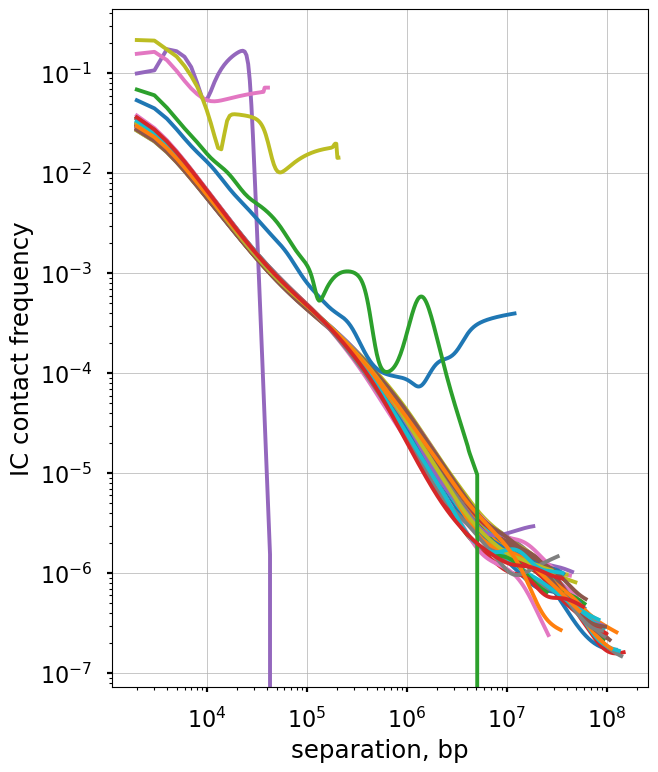

In [66]:
f, ax = plt.subplots(1,1)

for region in hg38_arms['name']:
    ax.loglog(
        cvd['1']['dist_bp'].loc[cvd['1']['region1']==region],
        cvd['1']['balanced.avg.smoothed'].loc[cvd['1']['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

f, ax = plt.subplots(1,1)

    

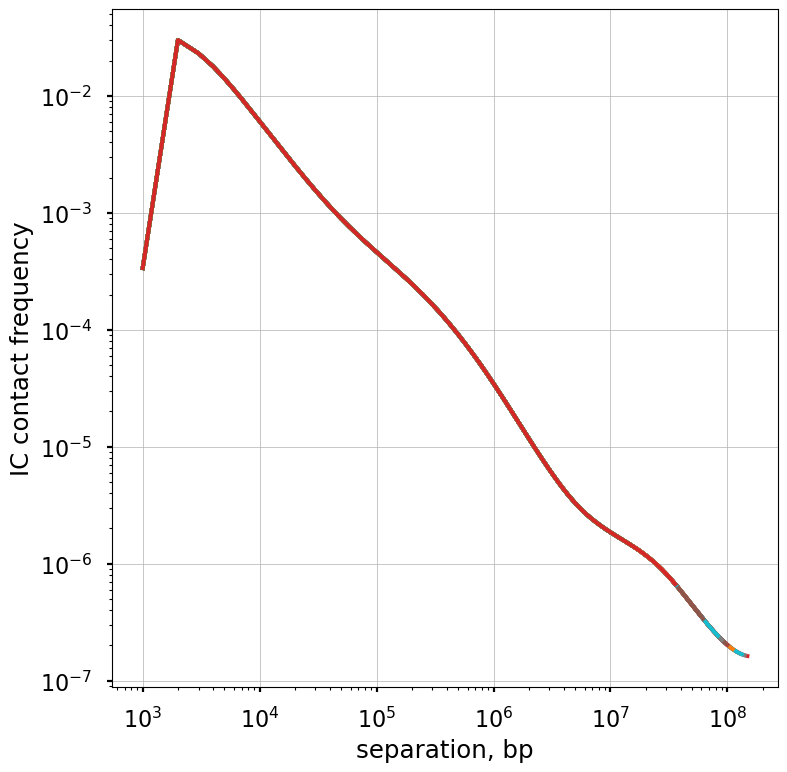

In [67]:
f, ax = plt.subplots(1,1)

for region in hg38_arms['name']:
    ax.loglog(
        cvd['1']['dist_bp'].loc[cvd['1']['region1']==region],
        cvd['1']['balanced.avg.smoothed.agg'].loc[cvd['1']['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)
    

In [68]:
# Calculate derivative in log-log space
der={}

for cond in conditions:
    der[cond] = np.gradient(np.log(cvd_merged[cond]['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged[cond]['dist_bp']))
    
der['1']


array([        nan,         nan,  1.9834881 , ..., -0.22357038,
       -0.22357038, -0.22357038])

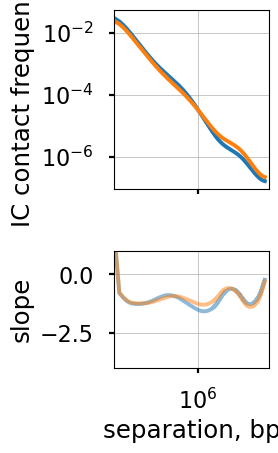

In [69]:
f, axs = plt.subplots(
    figsize=(2,5),
    nrows=2,
    gridspec_kw={'height_ratios':[4,2]},
    sharex=True)

ax = axs[0]
ax.loglog(
    cvd_merged['1']['dist_bp'],
    cvd_merged['1']['balanced.avg.smoothed.agg'],
    '-'
)
ax.loglog(
    cvd_merged['3']['dist_bp'],
    cvd_merged['3']['balanced.avg.smoothed.agg'],
    '-'
)

ax.set(
    ylabel='IC contact frequency',
    xlim=(2e3,2e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]
ax.semilogx(
    cvd_merged['1']['dist_bp'],
    der['1'],
    alpha=0.5
)
ax.semilogx(
    cvd_merged['3']['dist_bp'],
    der['3'],
    alpha=0.5
)

ax.set(
    xlabel='separation, bp',
    ylabel='slope',
    ylim=(-4,1))

ax.grid(lw=0.5)


# my plots

In [70]:
# long_names = {
#     '1':'ranGAP1-0-Ms-R1R2',
#     '2':'ranGAP1-2-Ms-R1R2',
    
#     '3':'ranGAP1-0-G1s-R1R2',
#     '4':'ranGAP1-7-G1s-R1R2',

#     '5':'N93-0-G1s-R1R2',
#     '6':'N93-7-G1s-R1R2',
    
#     '7':'ranGAP1-0-Telo-R2',
#     '8':'ranGAP1-4-Telo-R2',
#     '9':'ranGAP1-0-Cyto-R1',
#     '10':'ranGAP1-4-Cyto-R1'
# }

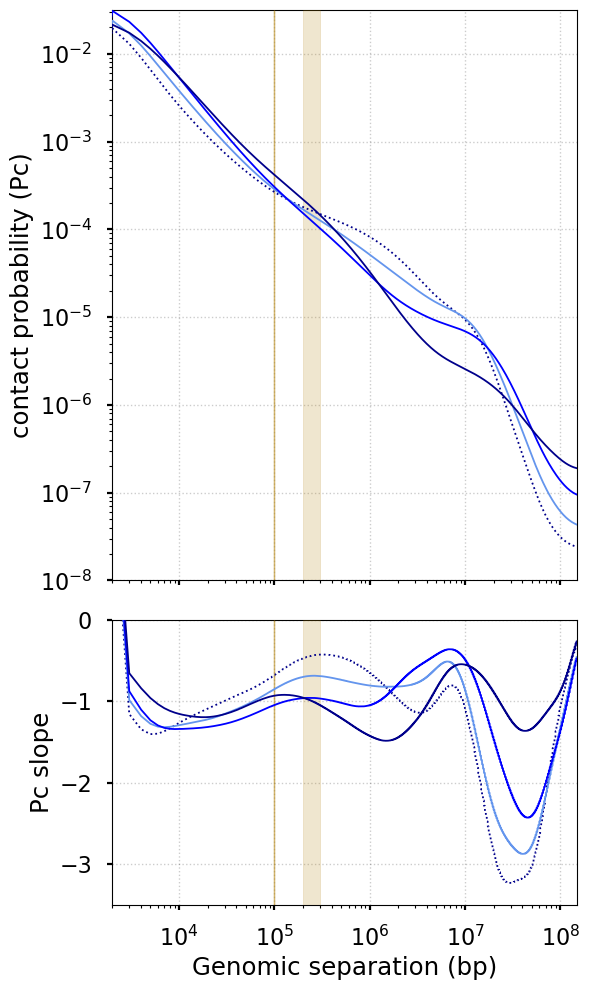

In [57]:
f, axs = plt.subplots(
    figsize=(6,10),
    nrows=2,
    gridspec_kw={'height_ratios':[4,2]},
    sharex=True)

colors={'1':'darkblue',
        '2':'darkred',
        '3':'darkblue',
        '4':'darkred',
        '7':'cornflowerblue',
        '8':'salmon',
        '9':'blue',
        '10':'red'
        
       }

linestyles={'1':':',
            '2':':',
            '3':'-',
            '4':'-',
            '7':'-',
            '8':'-',
            '9':'-',
            '10':'-'
       }
linewidths={'1':'1.3',
           '2':'1.3',
            '3':'1.3',
           '4':'1.3',
            '7':'1.3',
           '8':'1.3',
            '9':'1.3',
           '10':'1.3'
        }

labels={'1':'control: Mito',
        '2':'d: Mito',
        '3':'control: G1',
        '4':'d: G1',
        '7':'control: Telo',
        '8':'d: Telo',
        '9':'control: Cyto',
        '10':'d: Cyto'
}

# plotting actual Pc(s)
ax = axs[0]
for cond in ['1', '7','9', '3']:    
    ax.plot(cvd_merged[cond][["dist_bp"]], cvd_merged[cond][["balanced.avg.smoothed.agg"]], label=labels[cond], ls=linestyles[cond], color=colors[cond], lw=linewidths[cond],zorder=500)
    ax.set_ylabel("contact probability (Pc)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_ylim(10**-8, 10**-1.5)
    ax.set_xlim(2e3, 1.5e8)
    #plt.vlines(2000000, ymin=10**-7, ymax=10**-1.5, color='grey', ls='--', lw=1)
    ax.axvspan(200000,300000,color='darkgoldenrod',alpha=0.05,zorder=100)
    ax.vlines(100000, ymin=10**-8, ymax=10**-1.5,color='darkgoldenrod', ls='-', lw=1,alpha=0.2,zorder=100)
    ax.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2,zorder=10)
    #plt.rcParams['axes.facecolor']='ghostwhite' 

# plotting derivative
ax = axs[1]
for cond in ['1', '7','9', '3']:
    ax.plot(cvd_merged[cond][["dist_bp"]], der[cond],label=labels[cond], ls=linestyles[cond], color=colors[cond],lw=linewidths[cond],zorder=500)
    #plt.fill_between(der[cond][["diag.avg"]] * RESOLUTION, der[cond][["low_err"]], der[cond][["high_err"]], alpha=0.3)
    ax.set_ylabel("Pc slope")
    ax.set_xlabel("Genomic separation (bp)")
    ax.set_xscale("log")
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    ax.set_ylim(-3.5, 0)
    ax.set_xlim(2e3, 1.5e8)

    ax.axvspan(200000,300000,color='darkgoldenrod',alpha=0.05,zorder=100)
    ax.vlines(100000, ymin=-3.5, ymax=0,color='darkgoldenrod', ls='-', lw=1,alpha=0.2,zorder=100)
    ax.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2,zorder=10)
    #plt.rcParams['axes.facecolor']='ghostwhite' 
    
plt.tight_layout()
plt.savefig('',dpi = 300, bbox_inches='tight')


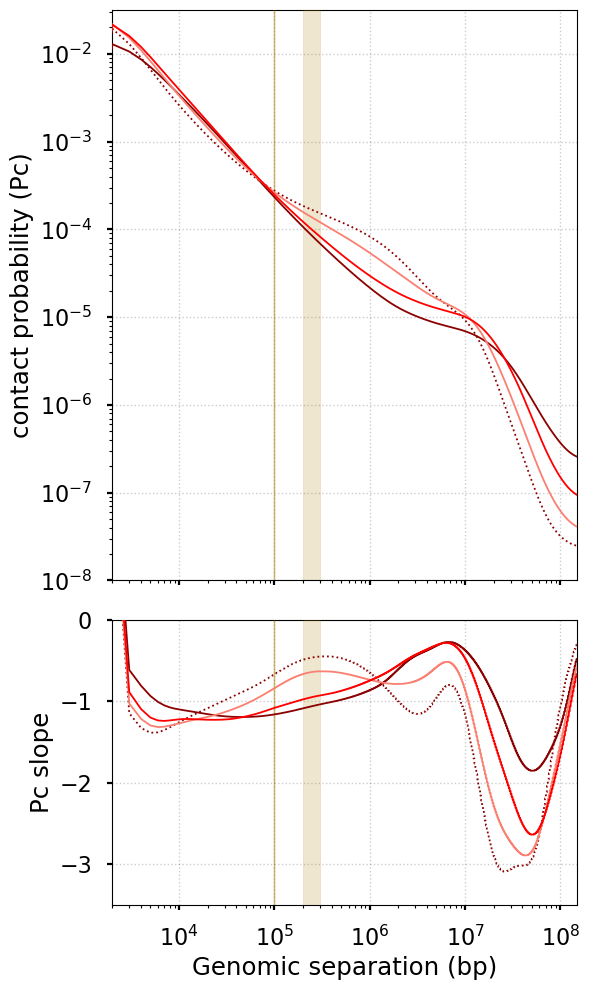

In [58]:
f, axs = plt.subplots(
    figsize=(6,10),
    nrows=2,
    gridspec_kw={'height_ratios':[4,2]},
    sharex=True)

colors={'1':'darkblue',
        '2':'darkred',
        '3':'darkblue',
        '4':'darkred',
        '7':'cornflowerblue',
        '8':'salmon',
        '9':'blue',
        '10':'red'
        
       }

linestyles={'1':':',
            '2':':',
            '3':'-',
            '4':'-',
            '7':'-',
            '8':'-',
            '9':'-',
            '10':'-'
       }
linewidths={'1':'1.3',
           '2':'1.3',
            '3':'1.3',
           '4':'1.3',
            '7':'1.3',
           '8':'1.3',
            '9':'1.3',
           '10':'1.3'
        }

labels={'1':'control: Mito',
        '2':'d: Mito',
        '3':'control: G1',
        '4':'d: G1',
        '7':'control: Telo',
        '8':'d: Telo',
        '9':'control: Cyto',
        '10':'d: Cyto'
}
# plotting actual Pc(s)
ax = axs[0]
for cond in ['2', '4','8', '10']:    
    ax.plot(cvd_merged[cond][["dist_bp"]], cvd_merged[cond][["balanced.avg.smoothed.agg"]], label=labels[cond], ls=linestyles[cond], color=colors[cond], lw=linewidths[cond],zorder=500)
    ax.set_ylabel("contact probability (Pc)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_ylim(10**-8, 10**-1.5)
    ax.set_xlim(1e3, 1.75e8)
    #plt.vlines(2000000, ymin=10**-7, ymax=10**-1.5, color='grey', ls='--', lw=1)
    ax.axvspan(200000,300000,color='darkgoldenrod',alpha=0.05,zorder=100)
    ax.vlines(100000, ymin=10**-8, ymax=10**-1.5,color='darkgoldenrod', ls='-', lw=1,alpha=0.2,zorder=100)
    ax.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2,zorder=10)
    #plt.rcParams['axes.facecolor']='ghostwhite' 

# plotting derivative
ax = axs[1]
for cond in ['2', '4','8', '10']:    
    ax.plot(cvd_merged[cond][["dist_bp"]], der[cond],label=labels[cond], ls=linestyles[cond], color=colors[cond],lw=linewidths[cond],zorder=500)
    #plt.fill_between(der[cond][["diag.avg"]] * RESOLUTION, der[cond][["low_err"]], der[cond][["high_err"]], alpha=0.3)
    ax.set_ylabel("Pc slope")
    ax.set_xlabel("Genomic separation (bp)")
    ax.set_xscale("log")
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    ax.set_ylim(-3.5, 0)
    ax.set_xlim(2e3, 1.5e8)
    
    #plt.vlines(2000000, ymin=-3, ymax=-0.2, color='grey', ls='--', lw=1)
    ax.axvspan(200000,300000,color='darkgoldenrod',alpha=0.05,zorder=100)
    ax.vlines(100000, ymin=-3.5, ymax=0,color='darkgoldenrod', ls='-', lw=1,alpha=0.2,zorder=100)
    ax.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2,zorder=10)
    #plt.rcParams['axes.facecolor']='ghostwhite' 
    
plt.tight_layout()
plt.savefig('',dpi = 300, bbox_inches='tight')

